In [30]:
from pathlib import Path
import requests
import string
from collections import Counter, defaultdict


import matplotlib.pyplot as plt
import numpy as np

In [31]:
data_path = Path('data')

In [32]:
shakespeare_path = data_path / 'Shakespeare.txt'
if not shakespeare_path.exists():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    response = requests.get(url)
    shakespeare_path.write_text(response.text)


In [242]:
with open(shakespeare_path, 'r') as f:
    shakespeare = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [300]:
# def simplify_text(text):
#     text = text.lower().strip()  # Convert to lowercase and remove leading/trailing white spaces
#     text = text.replace('\n', ' ')  # Replace newline characters with a space
#     text = text.replace('\r', ' ')  # Replace carriage return characters with a space
    
#     # Remove punctuation
#     text = ''.join(char for char in text if char not in string.punctuation)
    
#     # Replace multiple spaces with a single space
#     text = ' '.join(text.split())
#     # remove numbers
#     text = ''.join(char for char in text if not char.isdigit())
    
#     return text

import re

def simplify_text(text):
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing white spaces
    text = re.sub(r'[^a-z ]', '', text)  # Keep only alphabets and space
    text = ' '.join(text.split())  # Replace multiple spaces with a single space
    return text

In [56]:
def unique_characters(text):
    return len(set(text))

def n_gram_statistics(text, n, normalize=False):
    n_gram_counter = Counter(text[i:i+n] for i in range(len(text) - n + 1))
    
    if normalize:
        total = sum(n_gram_counter.values())
        return n_gram_counter, {k: v / total for k, v in n_gram_counter.items()}
    else:
        return n_gram_counter
    
    
def normalize_ngram_counts(n_gram_counter):
    # Create a defaultdict to hold the conditional probabilities
    conditional_probabilities = defaultdict(float)
    
    # Create a defaultdict to hold the sum of counts for each context
    context_totals = defaultdict(int)
    
    # First loop through to calculate the total counts for each context
    for ngram, count in n_gram_counter.items():
        context = ngram[:-1]
        context_totals[context] += count

    # Second loop through to normalize
    for ngram, count in n_gram_counter.items():
        context = ngram[:-1]
        conditional_probabilities[ngram] = count / context_totals[context]


    return conditional_probabilities

## Prepare a chunk of text for n-gram analysis

In [158]:
big_text = requests.get('http://norvig.com/big.txt').text

In [301]:
# /groups/pheno/inar/transformer-capacity/data/babylm_100M_clean/gutenberg.train

with open('/groups/pheno/inar/transformer-capacity/data/babylm_100M_clean/gutenberg.train', 'r') as f:
    gutenberg = f.read()
print(f"length of dataset in characters: {len(gutenberg):,}")

length of dataset in characters: 54,521,139


In [302]:
data =  big_text + shakespeare + gutenberg

In [303]:
text_chunk_size = len(data)
# text_chunk_size = len(data) // 100

print(f'percent of the full corpus: {text_chunk_size / len(data):.2%} %')

percent of the full corpus: 100.00% %


In [305]:
text = simplify_text(data[:text_chunk_size])
print(f"length of dataset in characters: {len(text):,}")

length of dataset in characters: 57,352,891


In [306]:
alphabet_len = unique_characters(text)
print(f"Number of unique characters: {alphabet_len}")

Number of unique characters: 27


In [309]:
actual_n_grams = []
computed_n_grams = defaultdict(dict)
normalized_n_grams = defaultdict(dict)

# Compute and store n-gram statistics up to 10-grams
for n in range(1, 11):
    actual_ngram_counter, norm_ngram_counter = n_gram_statistics(text, n, normalize=True)
    actual_count = len(actual_ngram_counter)
    

    actual_n_grams.append(actual_count)
    print(f"{n :2}-grams: {actual_count:,}")
    
    # Store the computed n-grams in the dictionary
    computed_n_grams[n] = actual_ngram_counter
    normalized_n_grams[n] = norm_ngram_counter

    


 1-grams: 27
 2-grams: 724
 3-grams: 12,902
 4-grams: 125,727
 5-grams: 652,707
 6-grams: 2,052,599
 7-grams: 4,680,527
 8-grams: 8,661,346
 9-grams: 13,840,124
10-grams: 19,827,795


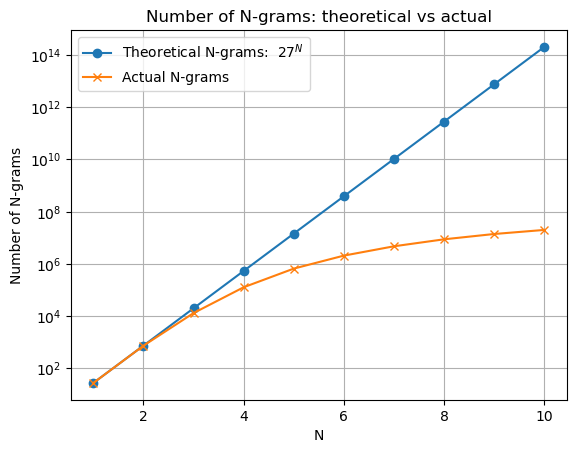

In [310]:
Ns = np.arange(1,len(actual_n_grams)+1)
plt.plot(Ns, alphabet_len**Ns, label='Theoretical N-grams:  $27^N$', marker='o')
plt.plot(Ns, actual_n_grams, label='Actual N-grams', marker='x')
plt.xlabel('N')
plt.ylabel('Number of N-grams')
plt.title('Number of N-grams: theoretical vs actual')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

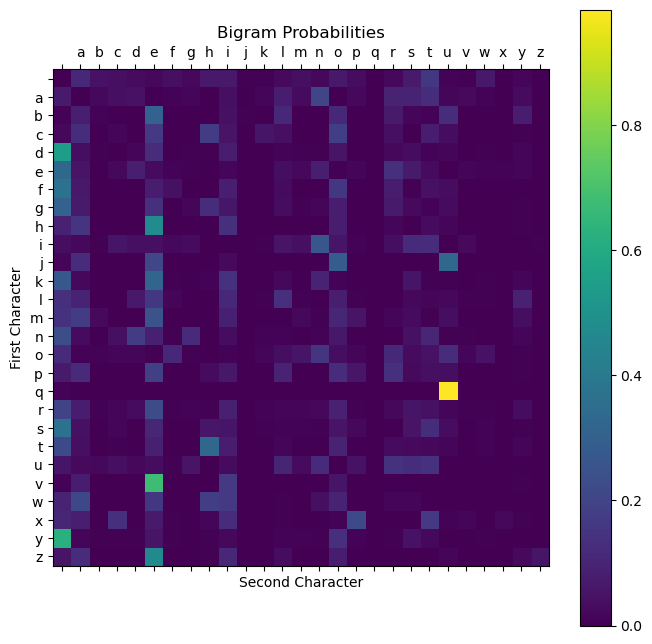

In [311]:
# Extract bigram probabilities from computed_n_grams
bigram_probabilities = normalize_ngram_counts(computed_n_grams[2])

# Extract the unique characters to define dimensions of the square table
unique_chars = sorted(list(set([char for bigram in bigram_probabilities.keys() for char in bigram])))

# Create an empty matrix filled with zeros
matrix_size = len(unique_chars)
bigram_matrix = np.zeros((matrix_size, matrix_size))

# Create a mapping from unique characters to indices
char_to_index = {char: index for index, char in enumerate(unique_chars)}

# Fill in the matrix with bigram probabilities
for bigram, probability in bigram_probabilities.items():
    x, y = bigram
    bigram_matrix[char_to_index[x], char_to_index[y]] = probability

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Create a heatmap
cax = ax.matshow(bigram_matrix, cmap="viridis")

# Add a colorbar
fig.colorbar(cax)

# Annotate the cells with probabilities
for i in range(matrix_size):
    for j in range(matrix_size):
        c = bigram_matrix[j, i]
        # ax.text(i, j, str(round(c, 2)), va='center', ha='center')

# Set axis labels
ax.set_xticks(np.arange(len(unique_chars)))
ax.set_yticks(np.arange(len(unique_chars)))
ax.set_xticklabels(unique_chars)
ax.set_yticklabels(unique_chars)

# Add labels and title
plt.xlabel('Second Character')
plt.ylabel('First Character')
plt.title('Bigram Probabilities')

plt.show()


In [312]:
bigram_matrix[char_to_index['q'], char_to_index['u']]

0.9847433238816709

## Computing entropy of N-grams


TODO: chek that the calculation of entropy is correct

In [313]:
def compute_entropy(probabilities):
    return -np.sum([p * np.log(p) for p in probabilities])

In [314]:


# Initialize a dictionary to store the entropy values for each 'n'
ngram_entropies = {}
Fn = {}
print(f'{0:2}, entropy: {np.log(alphabet_len):.3f} : uniform distribution')
ngram_entropies[0] = np.log(alphabet_len)
Fn[0] = np.log(alphabet_len)

# Compute entropy for each set of n-grams
for n, ngram_probabilities in normalized_n_grams.items():
    entropy = compute_entropy(list(ngram_probabilities.values()))
    ngram_entropies[n] = entropy
    if n == 1:
        fn = entropy
    else:
        fn = entropy - ngram_entropies[n-1]
    Fn[n] = fn
    print(f'{n:2}, joint entropy: {entropy:.3f}, Fn: {fn:.3f}')

# Now, ngram_entropies[n] will give you the entropy for the n-grams when 'n' is specified.
# For example, ngram_entropies[2] will give you the entropy for bigrams.


 0, entropy: 3.296 : uniform distribution
 1, joint entropy: 2.857, Fn: 2.857
 2, joint entropy: 5.224, Fn: 2.367
 3, joint entropy: 7.221, Fn: 1.997
 4, joint entropy: 8.900, Fn: 1.679
 5, joint entropy: 10.344, Fn: 1.444
 6, joint entropy: 11.629, Fn: 1.285
 7, joint entropy: 12.787, Fn: 1.159
 8, joint entropy: 13.821, Fn: 1.034
 9, joint entropy: 14.720, Fn: 0.899
10, joint entropy: 15.478, Fn: 0.757


In [316]:
print('in Shannons')
# Compute entropy for each set of n-grams
for n, fn in Fn.items():
    entropy = 1/np.log(2) * fn
    print(f'{n:2},  Fn: {entropy:.3f}')

in Shannons
 0,  Fn: 4.755
 1,  Fn: 4.122
 2,  Fn: 3.415
 3,  Fn: 2.881
 4,  Fn: 2.422
 5,  Fn: 2.083
 6,  Fn: 1.854
 7,  Fn: 1.672
 8,  Fn: 1.491
 9,  Fn: 1.297
10,  Fn: 1.093


In [317]:

def sample_from_ngrams(n, ngram_probabilities, seed, length=100):
    if len(seed) < n - 1:
        raise ValueError("Seed must be at least (n-1) characters long.")

    # Initialize the generated text with the seed
    generated_text = seed

    # Loop to generate 'length' number of characters
    for _ in range(length):
        # Extract the last (n-1) characters as context for the next character
        context = generated_text[-(n - 1):]

        # Get the possible next characters and their probabilities
        possible_next_chars = [k[-1] for k, v in ngram_probabilities.items() if k.startswith(context)]
        probabilities = [v for k, v in ngram_probabilities.items() if k.startswith(context)]

        if not possible_next_chars:
            # If no possible next characters, break the loop
            break

        # Sample the next character based on the probabilities
        next_char = np.random.choice(possible_next_chars, p=probabilities)
        
        # Append the next character to the generated text
        generated_text += next_char

    return generated_text




In [318]:
# Example usage
n = 3  # bigrams
seed = "to be or not to be"  # Must be at least (n-1) characters
length = 200  # Length of generated text
ngram_probabilities = normalize_ngram_counts(computed_n_grams[n])

generated_text = sample_from_ngrams(n, ngram_probabilities, seed, length)
print(generated_text)

to be or not to be gratsfar hebetwoutly cam rugh you knim to in noverse benight ponjust st the basimoren i a mento persters combeend this reappossnaxes fuld bet washe se cat tong to the of fired a this at itakininquid 


In [324]:

def compute_cross_entropy(text, n, ngram_probabilities):
    N = len(text) - n + 1  # Number of n-grams in text
    log_prob_sum = 0.0
    
    for i in range(N):
        ngram = text[i:i+n]
        # context = ngram[:-1]
        # target = ngram[-1]

        # Find the conditional probability of the target given the context
        conditional_prob = ngram_probabilities.get(ngram, 0)
        
        # Avoid log(0) by skipping terms where the probability is zero
        if conditional_prob > 0:
            log_prob_sum += np.log(conditional_prob)
        else:
            log_prob_sum += np.log(27) #we assume that if ngram is not in the corpus, its probability is 1/27
            
    if N == 0:
        return float('inf')  # Return infinity if no valid n-grams found
    
    cross_entropy = -log_prob_sum / N
    
    return cross_entropy




In [325]:
cross_entropies = []
text_sample = text[:100000]# You can adjust the length of the text sample as needed

for n in range(1, 11):
    conditional_probabilities = normalize_ngram_counts(computed_n_grams[n])
    cross_entropy = compute_cross_entropy(text_sample, n=n, ngram_probabilities=conditional_probabilities)
    cross_entropies.append(cross_entropy)
    print(f"{n :2}-gram Cross-entropy: {cross_entropy:.3f}")


 1-gram Cross-entropy: 2.840
 2-gram Cross-entropy: 2.332
 3-gram Cross-entropy: 1.921
 4-gram Cross-entropy: 1.586
 5-gram Cross-entropy: 1.358
 6-gram Cross-entropy: 1.218
 7-gram Cross-entropy: 1.118
 8-gram Cross-entropy: 1.021
 9-gram Cross-entropy: 0.914
10-gram Cross-entropy: 0.794


In [326]:
num_param = np.array(actual_n_grams)
cross_entropies = np.array(cross_entropies)

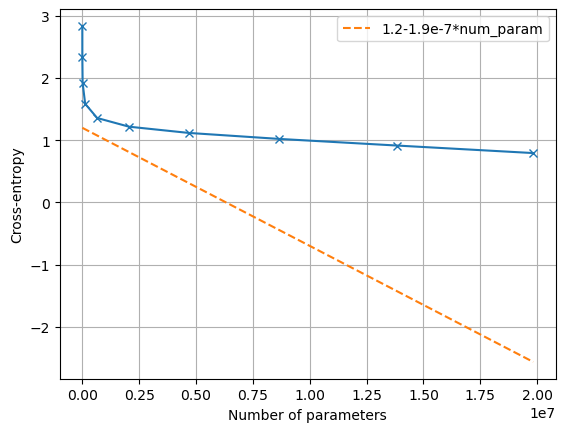

In [327]:
plt.plot(num_param, cross_entropies, marker='x')
plt.plot(num_param, 1.2-1.9e-7*num_param,'--', label = '1.2-1.9e-7*num_param')
plt.xlabel('Number of parameters')
plt.ylabel('Cross-entropy')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


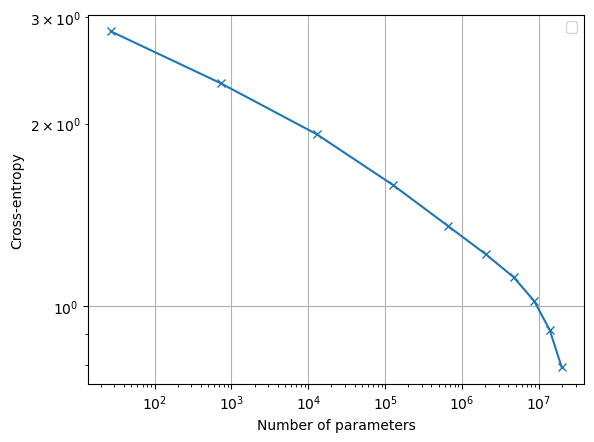

In [328]:
plt.loglog(num_param, cross_entropies, marker='x')
# plt.plot(num_param, 1.2-1.9e-7*num_param,'--', label = '1.2-1.9e-7*num_param')
plt.xlabel('Number of parameters')
plt.ylabel('Cross-entropy')
plt.legend()
plt.grid(True)
plt.show()